In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader as GeoDataLoader
from torch_geometric.nn import GCNConv

from src.get_data import collect_data_from_matches

from src.model_functions import build_graph_from_frame, TemporalRunnerDataset, TemporalRunnerGNN, train_model, collate_fn, predict_optimal_run

from src.visualization_tools import plot_soccer_pitch
from src.visualization_tools import animate_run
from src.visualization_tools import plot_spatial_graph
from src.visualization_tools import plot_optimal_run2

# Load Data

In [3]:
matches = [1886347]
possessions, run_features, tracking_data, player_to_team, merged = collect_data_from_matches(matches)


100%|██████████| 1/1 [00:38<00:00, 38.42s/it]


In [2]:
match_info = pd.read_csv("data/matches_info.csv")
possessions = pd.read_csv("data/possessions.csv")
run_features = pd.read_csv("data/run_features.csv")
tracking_data = pd.read_csv("data/tracking_data.csv")
player_to_team = pd.read_csv("data/player_team.csv").set_index("id")

merged = pd.merge(possessions,run_features,on=["match_id","possession_index"],how="outer",suffixes=("_possession","_run"))

merged["possession_lead_to_shot"] = (merged["possession_lead_to_shot"] | merged["lead_to_shot"])# Need to update wheter runs and possessions lead to shots on values that conflict
merged["possession_lead_to_goal"] = (merged["possession_lead_to_goal"] | merged["lead_to_goal"])


In [3]:
merged.event_subtype.unique()

array(['pulling_wide', 'coming_short', 'behind', nan, 'support',
       'overlap', 'cross_receiver', 'dropping_off',
       'run_ahead_of_the_ball', 'pulling_half_space', 'underlap'],
      dtype=object)

In [4]:
run_types_to_predict = ['cross_receiver','behind',"run_ahead_of_the_ball","overlap","underlap","support"]
runs_to_predict = merged[merged.event_subtype.isin(run_types_to_predict)]
run_type_vocab = {rt: i for i, rt in enumerate(sorted(run_types_to_predict))}

In [5]:
tracking_frame_groups = {
    (mid, rid): df
    for (mid, rid), df in tracking_data.groupby(
        ["match_id", "run_id"]
    )
}

# Validating that we can build graphs for each run

In [6]:
def validate_run(run_row):
    runner_id = run_row["player_id"]
    match_id = run_row["match_id"]
    run_id = run_row["event_id"]

    frame_start = int(run_row["frame_start_run"])
    frame_end = int(run_row["frame_end_run"])
    
    if frame_end - frame_start <= 10:
        return False

    tracking = tracking_frame_groups[(match_id, run_id)]

    lower_frame = frame_start-10
    
    if lower_frame < tracking["frame_id"].min():
        return False
    
    expected_frames = set(range(lower_frame, frame_end + 1))
    actual_frames = set(tracking["frame_id"].unique().tolist())

    if not expected_frames.issubset(actual_frames):
        return False
    
    runner_per_frame = (
        tracking
        .groupby("frame_id")["player"]
        .apply(lambda players: runner_id in players.values)
    )
    return runner_per_frame.all()
runs_to_predict = runs_to_predict[runs_to_predict.apply(validate_run,axis=1)]

In [7]:
runs_to_predict

,possession_index,match_id,period_possession,phases_indexes_possession,frame_start_possession,frame_end_possession,team_id_possession,phase_types,possession_lead_to_shot,possession_lead_to_goal,...,passing_option_score,predicted_passing_option,n_simultaneous_runs,passing_option_at_start,n_opponents_ahead_end,n_opponents_ahead_start,n_opponents_overtaken,run_curve_ratio,id,phases_indexes_run
2,0,1886347,1,"{np.int64(0), np.int64(1)}",28,107,1805,"{'create', 'direct'}",False,False,...,0.7705,True,2.0,False,2.0,4.0,2.0,0.007974,1_2,1.0
6,3,1886347,1,{np.int64(5)},301,351,4177,{'finish'},False,False,...,0.9433,True,2.0,True,0.0,6.0,6.0,0.028686,1_5,5.0
8,3,1886347,1,{np.int64(5)},301,351,4177,{'finish'},False,False,...,0.7773,True,0.0,True,4.0,5.0,1.0,0.014079,1_7,5.0
21,8,1886347,1,"{np.int64(13), np.int64(14), np.int64(15), np....",1091,1546,1805,"{'build_up', 'finish', 'create', 'chaotic'}",True,False,...,0.9504,True,0.0,True,10.0,10.0,0.0,0.030112,1_18,18.0
23,8,1886347,1,"{np.int64(13), np.int64(14), np.int64(15), np....",1091,1546,1805,"{'build_up', 'finish', 'create', 'chaotic'}",True,False,...,0.9296,True,1.0,False,1.0,3.0,2.0,0.008746,1_20,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6151,307,2017461,2,{np.int64(433)},69416,69508,4177,{'transition'},True,False,...,0.8647,True,0.0,True,1.0,1.0,0.0,0.006744,1_453,433.0
6152,308,2017461,2,"{np.int64(434), np.int64(435), np.int64(436)}",69508,69868,868,"{'build_up', 'finish', 'create'}",True,False,...,0.7520,True,0.0,True,6.0,7.0,1.0,0.002256,1_454,435.0
6153,308,2017461,2,"{np.int64(434), np.int64(435), np.int64(436)}",69508,69868,868,"{'build_up', 'finish', 'create'}",True,False,...,0.8043,True,0.0,True,5.0,5.0,0.0,0.010304,1_455,436.0
6154,308,2017461,2,"{np.int64(434), np.int64(435), np.int64(436)}",69508,69868,868,"{'build_up', 'finish', 'create'}",True,False,...,0.9742,True,1.0,False,7.0,7.0,0.0,0.015923,1_456,436.0


<Axes: >

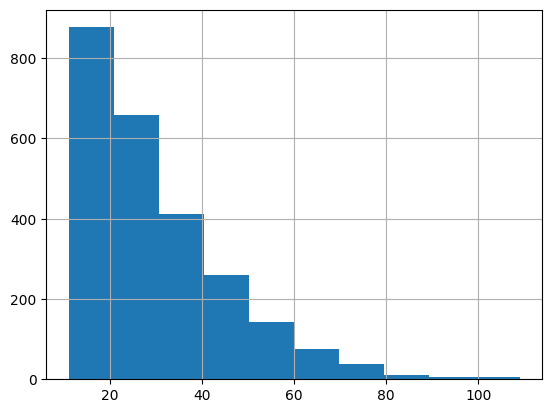

In [8]:
(runs_to_predict["frame_end_run"] - runs_to_predict["frame_start_run"]).hist()

# Build Graph

In [9]:
RUN_NUM = 0
RUN_FRAME = 2
run = runs_to_predict.iloc[RUN_NUM]
match_id = run["match_id"]
run_id = run["id"]
player = run["player_id"]

run_tracking = tracking_data[(tracking_data.run_id == run_id) & (tracking_data.match_id == match_id)]
run_tracking["timestamp"] = pd.to_timedelta(run_tracking["timestamp"]).dt.total_seconds()
frame_num = run_tracking["frame_id"].sort_values().iloc[0] + RUN_FRAME
frame_df = run_tracking[run_tracking["frame_id"]==frame_num]


graph = build_graph_from_frame(frame_df=frame_df,runner_player_id=player,player_to_team=player_to_team)
graph

Data(x=[23, 10], edge_index=[2, 506], edge_attr=[506, 4], runner_idx=21, team_ids=[23], is_ball=[23])

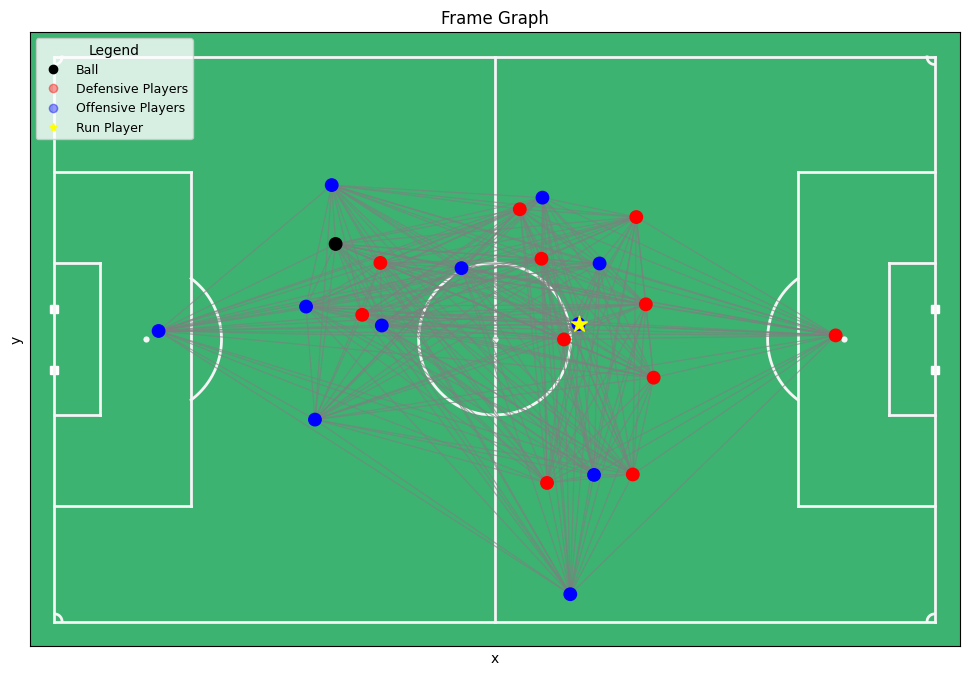

In [10]:
%matplotlib inline
plot_spatial_graph(graph)

In [11]:
run_type_vocab

{'behind': 0,
 'cross_receiver': 1,
 'overlap': 2,
 'run_ahead_of_the_ball': 3,
 'support': 4,
 'underlap': 5}

# Temporal Dataset class

In [12]:
dataset = TemporalRunnerDataset(
    tracking_df=tracking_frame_groups,
    run_features=runs_to_predict,
    player_to_team=player_to_team,
    run_type_vocab=run_type_vocab
)
dataset

# Temporal GNN

In [ ]:
node_feat_dim = 10
edge_dim = 4
gnn_hidden_dim = 64   
K = len(run_type_vocab)
model = TemporalRunnerGNN(node_feat_dim,edge_dim,gnn_hidden_dim,K)

# Training Loop

In [14]:
from torch.utils.data import DataLoader
dataloader = DataLoader(
    dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=collate_fn
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = train_model(model,device = device, dataloader=dataloader,num_epochs=10,output_file="models/temporal_runner_test.pth")


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [3:36:52<00:00, 1301.26s/it] 


# Load Model From Saved State

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TemporalRunnerGNN(node_feat_dim,edge_dim,gnn_hidden_dim,K)
model.load_state_dict(torch.load("models/temporal_runner_test.pth"))
model.to(device)
model.eval() 

TemporalRunnerGNN(
  (gnn1): TransformerConv(10, 64, heads=4)
  (gnn2): TransformerConv(64, 64, heads=4)
  (temporal_proj): Linear(in_features=80, out_features=64, bias=True)
  (temporal_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (run_type_head): Linear(in_features=64, out_features=6, bias=True)
  (run_type_emb): Embedding(6, 16)
  (pos_head):

# Given tracking data and runner id predict optimal run path

In [40]:
def predict_optimal_run2(run,model,tracking_frame_groups,device,player_to_team,run_type_vocab):
    """
    Predict optimal run types, shot probabilities, and future run paths for a given run.

    Args:
        run (pd.Series): A row from dynamic event data off ball run dataframe
        model (nn.Module): Trained TemporalRunnerGNN model.
        tracking_frame_groups (dict): Grouped tracking DataFrame indexed by (match_id, event_id).
        device (torch.device): Device to run inference on.
        player_to_team (pd.DataFrame): Mapping from player IDs to their team IDs.
        run_type_vocab (dict): Mapping from run type string to integer index.

    Returns:
        dict: Keys are run types (str), values are dicts with:
              - "run_type_prob": predicted probability of that run type,
              - "shot_prob": predicted shot probability for that run type,
              - "run_path": predicted future run path (numpy array).
    """
    match_id = run['match_id']
    run_id = run['event_id']
    runner_id = run['player_id']
    team_id = run["team_id"]
    frame_start = int(run['frame_start_run'])
    frame_end = int(run['frame_end_run'])

    run_tracking = tracking_frame_groups[(match_id, run_id)].sort_values('frame_id')

    graphs = []
    for t in range(frame_start, frame_end + 1):
        frame_df = run_tracking[run_tracking['frame_id'] == t]
        g = build_graph_from_frame(
            frame_df=frame_df,
            runner_player_id=runner_id,
            player_to_team=player_to_team
        )
        graphs.append(g)
        
    graphs_batch = Batch.from_data_list(graphs)
    length = len(graphs)
        
    lengths = [length]
    graphs_batch = graphs_batch.to(device)

    with torch.no_grad():
        output = model(graphs_batch, lengths)  
    run_type_probs = output["run_type_probs"].squeeze(0)
    shot_probs_per_type = output["shot_probs_per_type"].squeeze(0)
    run_paths_per_type = output["run_paths_per_type"].squeeze(0)
    shot_probs_per_type = shot_probs_per_type.numpy()
    run_type_probs = run_type_probs.numpy()
    run_paths_per_type = run_paths_per_type.numpy()

    x0, y0 = run[["x_start","y_start"]]
    run_type_dict = {
        run_type: {
            "run_type_prob": run_type_probs[idx],
            "shot_prob": shot_probs_per_type[idx],
            "run_coords":run_paths_per_type[idx],
            "run_path": run_paths_per_type[idx] + np.array([x0,y0]),
        }
        for run_type, idx in run_type_vocab.items()
    }
    return run_type_dict

In [41]:
model.eval()
T = 10
RUN_NUM = 4
run = runs_to_predict.iloc[RUN_NUM]
match_id = run['match_id']
run_id = run['event_id']
runner_id = run['player_id']
team_id = run["team_id"]

pred_output = predict_optimal_run2(run,model,tracking_frame_groups=tracking_frame_groups,device = device,player_to_team = player_to_team,run_type_vocab=run_type_vocab)

In [42]:
pred_output

{'behind': {'run_type_prob': np.float32(0.1119113),
  'shot_prob': np.float32(0.05192054),
  'run_coords': array([[ 0.14294645, -0.12189571],
         [ 0.51814556, -0.11433093],
         [ 0.978606  , -0.10432447],
         [ 1.3770045 , -0.09228548],
         [ 1.8043443 , -0.07882106],
         [ 2.2901742 , -0.06611963],
         [ 2.7363403 , -0.05635051],
         [ 3.2217004 , -0.04835748],
         [ 3.702205  , -0.04228077],
         [ 4.184429  , -0.03751606],
         [ 4.678496  , -0.03317026],
         [ 5.1945806 , -0.02999661],
         [ 5.661572  , -0.03287328],
         [ 6.127092  , -0.03163181],
         [ 6.6977363 , -0.03352151],
         [ 7.2127757 , -0.03164924],
         [ 7.7651677 , -0.03382102],
         [ 8.324235  , -0.0327627 ],
         [ 8.903825  , -0.03690762],
         [ 9.433722  , -0.03717696],
         [10.027257  , -0.04627372],
         [10.596898  , -0.05102844],
         [11.166287  , -0.05777357],
         [11.760078  , -0.05833813],
       

# Plot Optimal Run Path

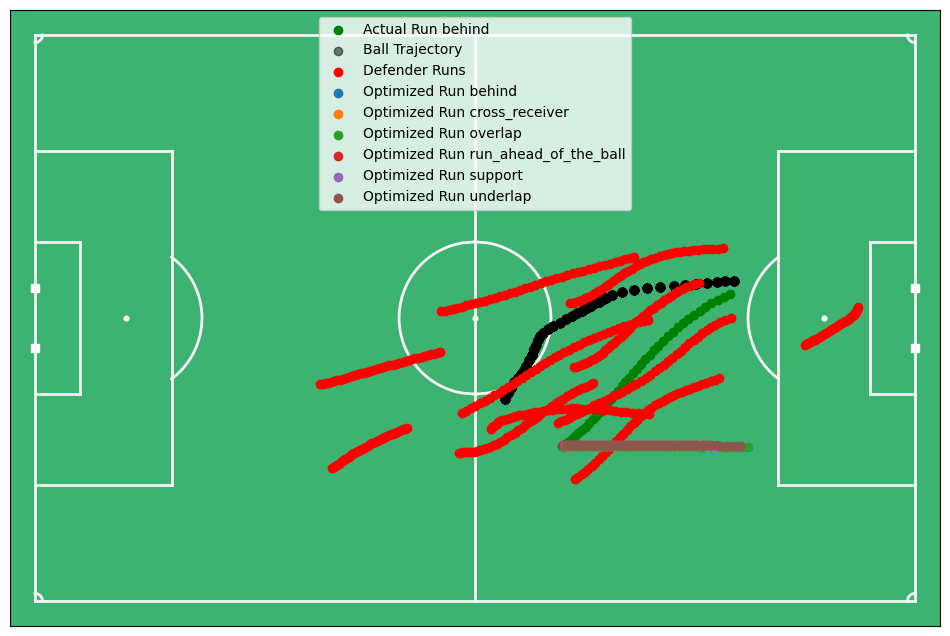

In [38]:
%matplotlib inline
def plot_optimal_run2(run, tracking_frame_groups,player_to_team, run_dict, plot_ball = True,plot_defense = True):
    match_id = run['match_id']
    run_id = run['event_id']
    runner_id = run['player_id']
    team_id = run["team_id"]
    run_type = run["event_subtype"]

    fig,ax = plot_soccer_pitch()

    run_tracking = tracking_frame_groups[(match_id, run_id)].sort_values('frame_id')
    active_run = run_tracking[run_tracking.run_active]
    actual_points = active_run[(active_run.player == runner_id)][["x","y"]]
    real_x = actual_points.values[:,0]
    real_y = actual_points.values[:,1]
    plt.scatter(x=real_x,y=real_y,color="green",label=f"Actual Run {run_type}")

    if plot_ball == True:
        ball_coords = active_run.iloc[:, ["ball" in col for col in active_run.columns]]
        ball_x = ball_coords.loc[:, "ball_x"].values
        ball_y = ball_coords.loc[:, "ball_y"].values
        ax.scatter(ball_x, ball_y, color="black", alpha=0.5, label="Ball Trajectory")

    if plot_defense == True:
        defender_frames = active_run[(active_run["player"].apply(lambda id: player_to_team.loc[id])!=team_id).values[:,0]]
        def_x = defender_frames["x"]
        def_y = defender_frames["y"]
        plt.scatter(x=def_x,y=def_y,color="red",label = "Defender Runs")
    
    for run_type in run_dict:
        absolute_path = run_dict[run_type]["run_path"]
        pred_x = pd.Series(absolute_path[:,0])
        pred_y = pd.Series(absolute_path[:,1])
        plt.scatter(x=pred_x,y=pred_y,label = f"Optimized Run {run_type}")

    plt.legend()
    plt.show()
plot_optimal_run2(run,tracking_frame_groups=tracking_frame_groups,player_to_team=player_to_team,run_dict = pred_output)

# Animate Optimal Run

In [266]:
# Transform for animation
run_tracking = tracking_frame_groups[(match_id, run_id)].sort_values('frame_id')
pred_x = pd.Series(absolute_path[:,0])
pred_y = pd.Series(absolute_path[:,1])
dx = pred_x - pred_x.shift(1)
dy = pred_y - pred_y.shift(1)
s = np.sqrt(dx**2 + dy**2) * 10
d = np.arctan2(dy,dx)
pred_vals = pd.concat([pred_x,pred_y,dx,dy,s,d],axis=1)
pred_vals.columns = ["x","y","dx","dy","s","d"]
pred_vals["player"] = -1
pred_run = run_tracking[(run_tracking.run_active) & (run_tracking.player==runner_id)].copy()
pred_run.loc[:,["x","y","dx","dy","s","d","player"]] = pred_vals.fillna(0).values

In [267]:
%matplotlib tk

run_tracking_with_pred = pd.concat([run_tracking,pred_run])
animate_run(run=run,tracking_data=run_tracking_with_pred,player_to_team=player_to_team)